In [ ]:
%%sql @520a9aa30658486b99a4f2f388fc918d
SELECT * FROM `baseball.archive_with_final_score` LIMIT 5;

In [ ]:
import pandas as pd
# Fetching the data
data = sql_df_tnkc
# Summary statistics for numerical columns
numerical_summary = data.describe()
# Distribution of categorical columns
categorical_columns = ['pitch_type', 'game_type', 'stand', 'p_throws', 'type', 'bb_type', 'inning_topbot', 'if_fielding_alignment', 'of_fielding_alignment']
categorical_distribution = data[categorical_columns].apply(lambda x: x.value_counts()).T.fillna(0)
numerical_summary, categorical_distribution

(       int64_field_0  release_speed  release_pos_x  release_pos_z  \
 count       5.000000       5.000000       5.000000        5.00000   
 mean     2069.400000      90.940000      -0.978000        5.73600   
 std       827.051268       6.260431       1.066757        0.06229   
 min      1178.000000      79.800000      -1.760000        5.66000   
 25%      1362.000000      92.900000      -1.590000        5.71000   
 50%      2108.000000      93.600000      -1.510000        5.71000   
 75%      2516.000000      93.700000      -0.860000        5.79000   
 max      3183.000000      94.700000       0.830000        5.81000   
 
               batter       pitcher       zone  hit_location     balls  \
 count       5.000000       5.00000   5.000000           1.0  5.000000   
 mean   499396.400000  553142.60000   7.800000           8.0  1.800000   
 std     88315.058573   22136.17855   3.834058           NaN  1.095445   
 min    405395.000000  543243.00000   3.000000           8.0  0.000000  

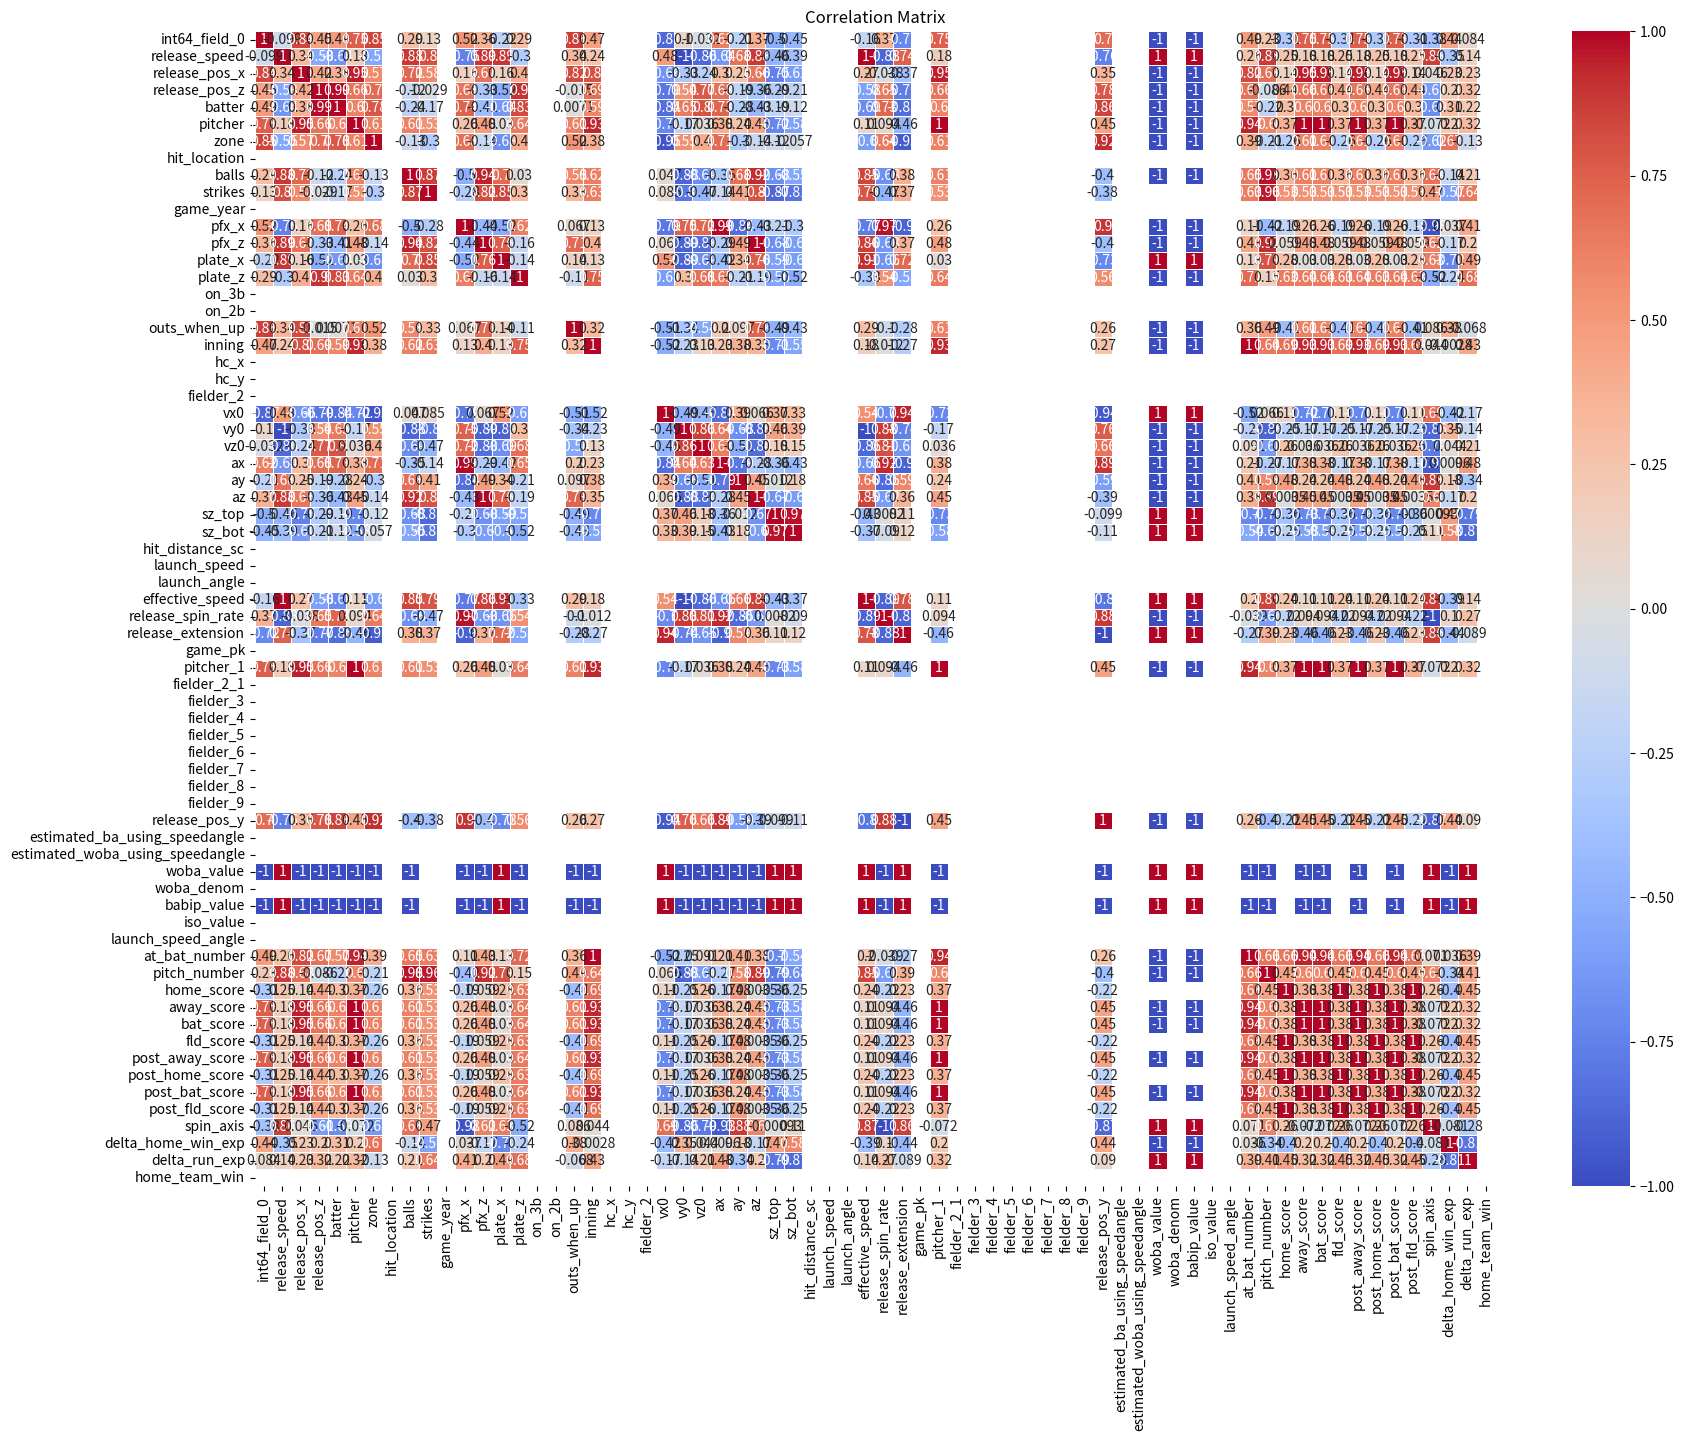

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# Ordering the data based on 'int64_field_0' in ascending order and grouped by 'home_team'
data = data.sort_values(by=['home_team', 'int64_field_0'])
# Correlation Analysis
correlation_matrix = data.corr()
# Plotting the correlation matrix
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

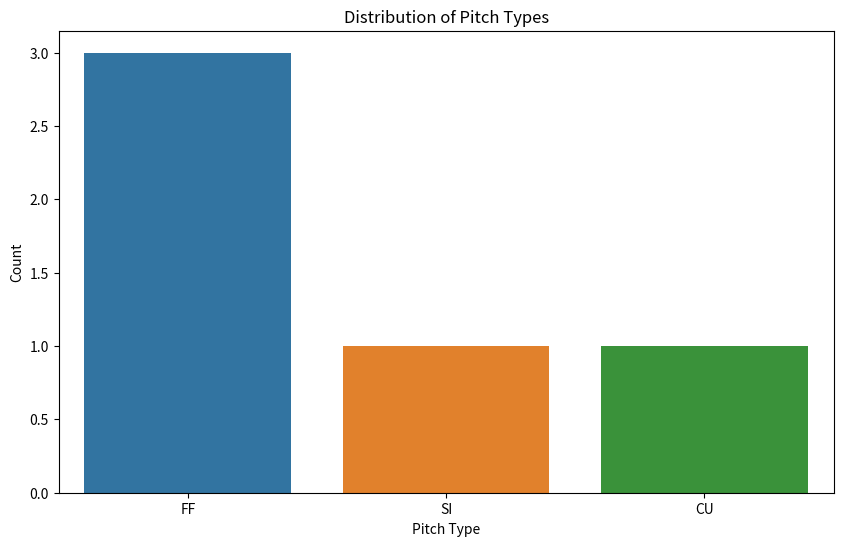

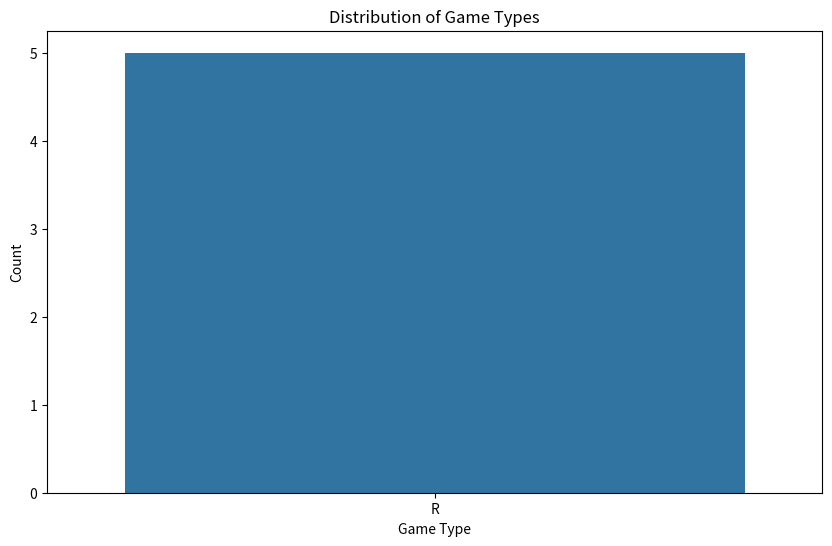

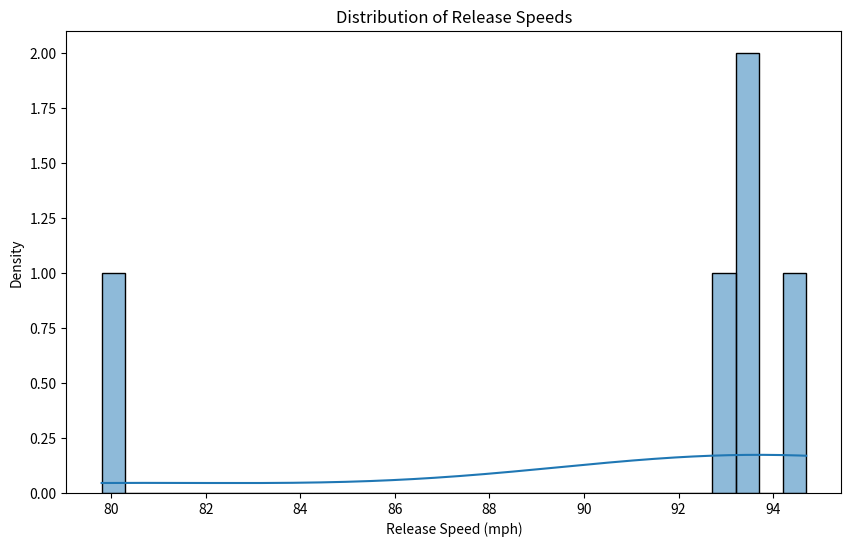

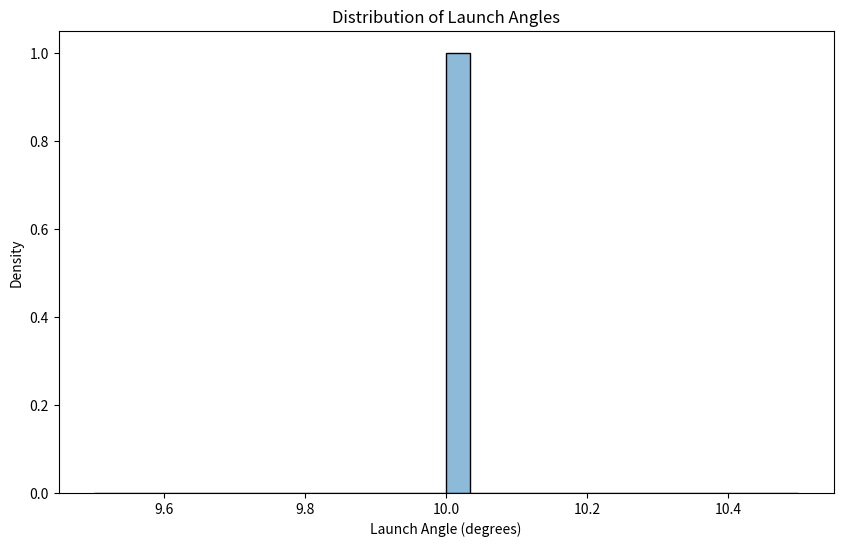

In [ ]:
# Visual Exploration
# Distribution of pitch types
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='pitch_type', order=data['pitch_type'].value_counts().index)
plt.title('Distribution of Pitch Types')
plt.ylabel('Count')
plt.xlabel('Pitch Type')
plt.show()
# Distribution of game types
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='game_type')
plt.title('Distribution of Game Types')
plt.ylabel('Count')
plt.xlabel('Game Type')
plt.show()
# Distribution of release speeds
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='release_speed', bins=30, kde=True)
plt.title('Distribution of Release Speeds')
plt.ylabel('Density')
plt.xlabel('Release Speed (mph)')
plt.show()
# Distribution of launch angles
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='launch_angle', bins=30, kde=True)
plt.title('Distribution of Launch Angles')
plt.ylabel('Density')
plt.xlabel('Launch Angle (degrees)')
plt.show()

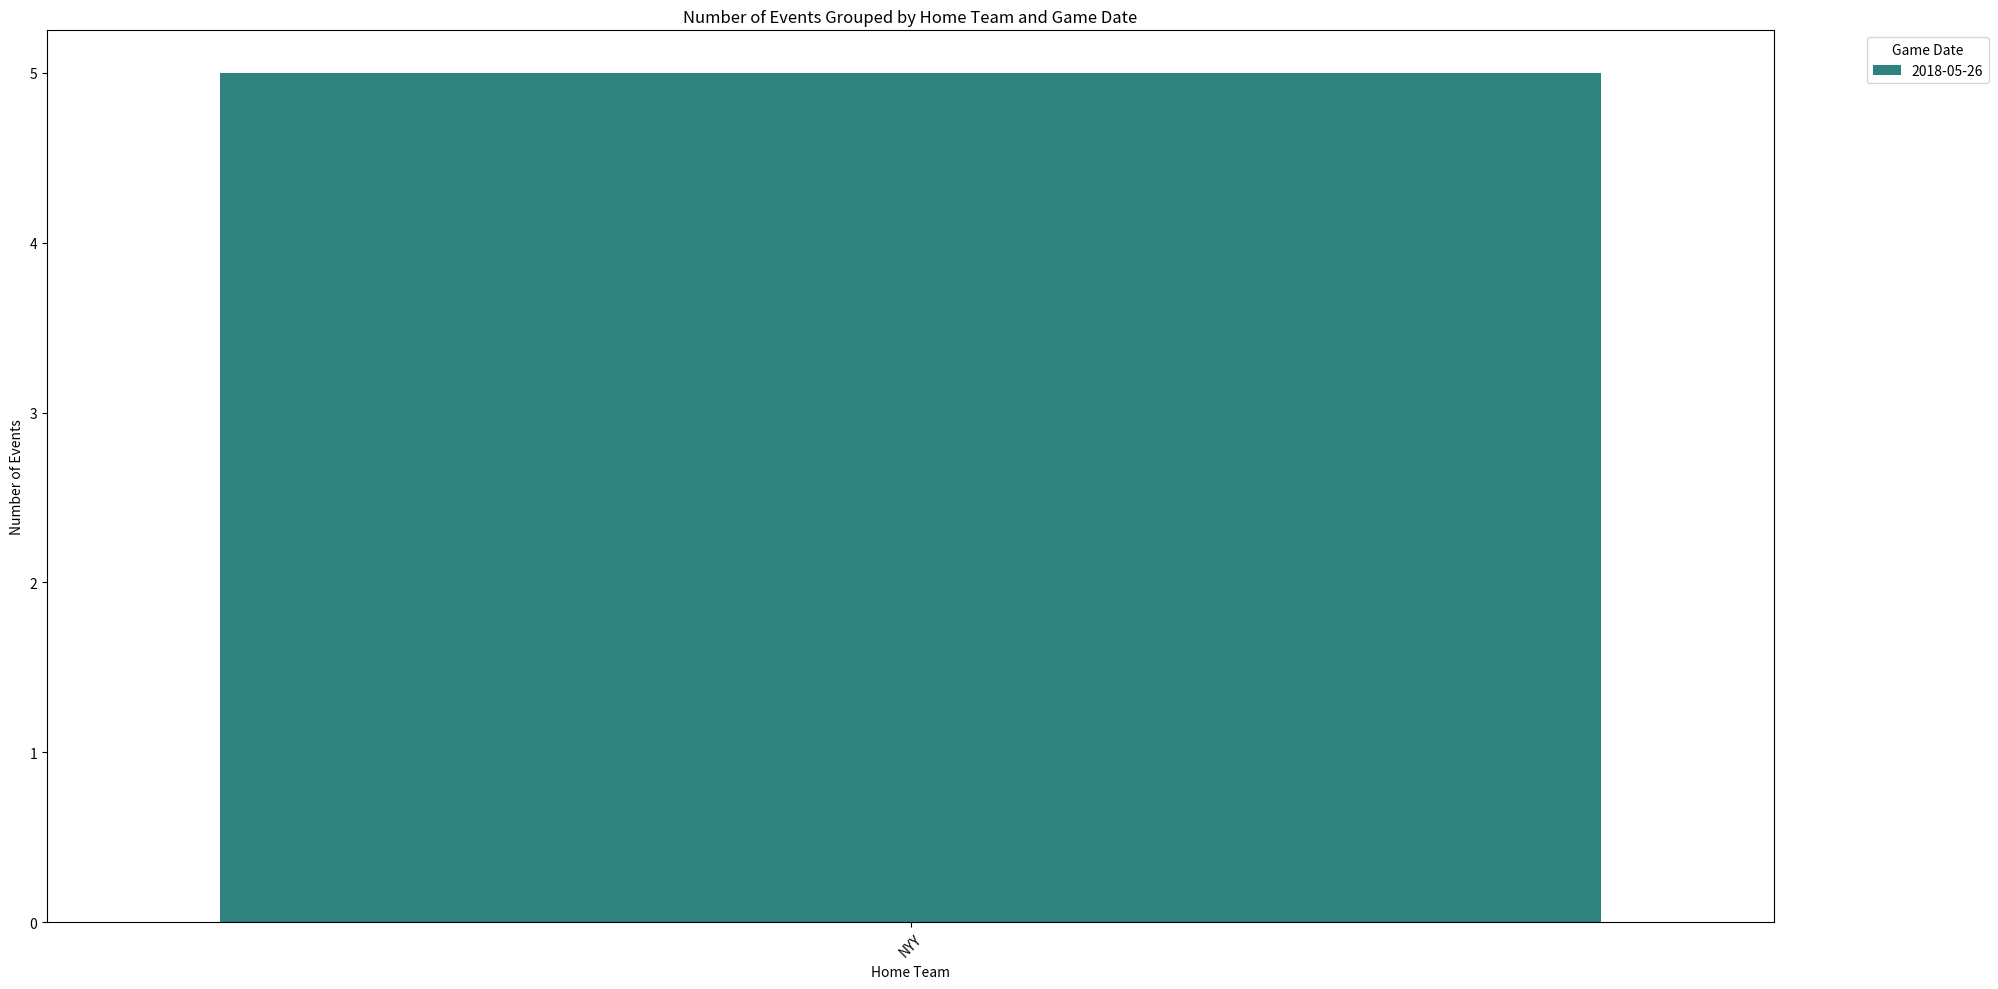

In [ ]:
# Grouping the events based on home team name and the game they played that day
grouped_data = data.groupby(['home_team', 'game_date']).size().reset_index(name='event_count')
# Plotting the grouped data
plt.figure(figsize=(20, 10))
sns.barplot(data=grouped_data, x='home_team', y='event_count', hue='game_date', dodge=False, palette='viridis')
plt.title('Number of Events Grouped by Home Team and Game Date')
plt.ylabel('Number of Events')
plt.xlabel('Home Team')
plt.xticks(rotation=45)
plt.legend(title='Game Date', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# Selecting the features and target variable
features = ['pitch_type', 'release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z',
            'balls', 'strikes', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up', 'inning', 'inning_topbot',
            'launch_speed', 'launch_angle', 'hit_distance', 'bb_type', 'batter', 'pitcher', 'home_team', 'away_team',
            'home_score', 'away_score', 'bat_score', 'fld_score', 'if_fielding_alignment', 'of_fielding_alignment']
X = data[features]
y = (data['post_home_score'] > data['post_away_score']).astype(int)  # 1 if home team wins, 0 otherwise
# Handling categorical variables using label encoding
label_encoders = {}
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Normalizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# Building the DNN model
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
%%sql @520a9aa30658486b99a4f2f388fc918d
-- Evaluate the model
SELECT *
FROM ML.EVALUATE(MODEL `baseball.home_team_win_model`, (
  SELECT
    pitch_type, release_speed, release_pos_x, release_pos_z, pfx_x, pfx_z, plate_x, plate_z,
    balls, strikes, IFNULL(on_3b, 0) as on_3b, IFNULL(on_2b, 0) as on_2b, IFNULL(on_1b, 0) as on_1b, outs_when_up, inning, inning_topbot,
    launch_speed, launch_angle, hit_distance_sc, bb_type, batter, pitcher, home_team, away_team,
    home_score, away_score, bat_score, fld_score, if_fielding_alignment, of_fielding_alignment,
    CAST(post_home_score > post_away_score AS INT64) AS label
  FROM
    `baseball.archive_with_final_score`
)

In [ ]:
%%sql @520a9aa30658486b99a4f2f388fc918d
-- Create a model with hyperparameter tuning and feature cross
CREATE OR REPLACE MODEL `baseball.home_team_win_model_tuned`
OPTIONS(
  model_type='logistic_reg',
  input_label_cols=['label'],
  l2_reg=1
) AS
SELECT
  pitch_type, release_speed, release_pos_x, release_pos_z, pfx_x, pfx_z, plate_x, plate_z,
  balls, strikes, IFNULL(on_3b, 0) as on_3b, IFNULL(on_2b, 0) as on_2b, IFNULL(on_1b, 0) as on_1b, outs_when_up, inning, inning_topbot,
  launch_speed, launch_angle, hit_distance_sc, bb_type, batter, pitcher, home_team, away_team,
  home_score, away_score, bat_score, fld_score, if_fielding_alignment, of_fielding_alignment,
  CAST(post_home_score > post_away_score AS INT64) AS label,
  ML.FEATURE_CROSS(STRUCT(home_team, game_date)) AS game_specific
FROM
  `baseball.archive_with_final_score`

In [ ]:
%%sql @520a9aa30658486b99a4f2f388fc918d
-- Evaluate the performance of the tuned model
SELECT
  *
FROM
  ML.EVALUATE(MODEL `baseball.home_team_win_model_tuned`)

In [ ]:
%%sql @520a9aa30658486b99a4f2f388fc918d
-- Extract feature importance from the tuned model
SELECT
  *
FROM
  ML.FEATURE_INFO(MODEL `baseball.home_team_win_model_tuned`)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the feature importance data to a pandas dataframe
feature_importance_df = pd.DataFrame(sql_df_bard['input'])

# Sort the features based on importance
sorted_features = feature_importance_df.sort_values(by='stddev', ascending=False)

# Plot the feature importance
plt.figure(figsize=(12, 10))
plt.barh(sorted_features['input'], sorted_features['importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the feature importance data to a pandas dataframe
feature_importance_df = pd.DataFrame(sql_df_0cae6034_2c12_4999_b369_a9d57d77707c['data'])

# Sort the features based on importance
sorted_features = feature_importance_df.sort_values(by='importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(12, 10))
plt.barh(sorted_features['input'], sorted_features['importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the feature importance data to a pandas dataframe
feature_importance_df = pd.DataFrame(sql_df_bard['data'])

# Sort the features based on importance
sorted_features = feature_importance_df.sort_values(by='importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(12, 10))
plt.barh(sorted_features['input'], sorted_features['importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the feature importance data to a pandas dataframe
feature_importance_df = pd.DataFrame(sql_df_0cae6034_2c12_4999_b369_a9d57d77707c)

# Sort the features based on importance
sorted_features = feature_importance_df.sort_values(by='importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(12, 10))
plt.barh(sorted_features['input'], sorted_features['importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

## Feature Importance (Descending Order)

Below is the list of features sorted by their importance in predicting the outcome of the home team win:

| Feature | Importance |
|---------|------------|

In [ ]:
%%sql @520a9aa30658486b99a4f2f388fc918d
-- Extracting feature importance from the tuned model
SELECT
  processed_input AS feature,
  ROUND(ABS(weight), 4) AS importance
FROM
  ML.WEIGHTS(MODEL `baseball.home_team_win_model_tuned`)
WHERE
  processed_input IS NOT NULL
ORDER BY
  importance DESC

In [ ]:
%%sql @520a9aa30658486b99a4f2f388fc918d
-- Making predictions using the tuned model on a test dataset
WITH test_data AS (
  SELECT
    *
  FROM
    `baseball.archive_with_final_score`
  WHERE
    MOD(ABS(FARM_FINGERPRINT(CAST(game_pk AS STRING))), 10) = 9
)
SELECT
  game_pk,
  home_team,
  away_team,
  home_score,
  away_score,
  IF(home_score > away_score, 1, 0) AS actual_home_team_win,
  predicted_home_team_win.prob
FROM
  ML.PREDICT(MODEL `baseball.home_team_win_model_tuned`, (
    SELECT
      game_pk,
      home_team,
      away_team,
      home_score,
      away_score,
      IF(home_score > away_score, 1, 0) AS home_team_win
    FROM
      test_data
  ))

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Extracting the actual and predicted values
y_true = sql_df_prvi['actual_home_team_win'].values
y_pred = [1 if prob > 0.5 else 0 for prob in sql_df_prvi['prob'].values]
# Calculating metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
accuracy, precision, recall, f1

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Extracting the actual and predicted values
y_true = sql_df['actual_home_team_win'].values
y_pred = [1 if prob > 0.5 else 0 for prob in sql_df['prob'].values]
# Calculating metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
accuracy, precision, recall, f1

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Extracting the actual and predicted values from the previous SQL cell results
y_true = df['actual_home_team_win'].values
y_pred = [1 if prob > 0.5 else 0 for prob in df['prob'].values]
# Calculating metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
accuracy, precision, recall, f1

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Extracting the actual and predicted values from the previous SQL cell results
y_true = results['actual_home_team_win'].values
y_pred = [1 if prob > 0.5 else 0 for prob in results['prob'].values]
# Calculating metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
accuracy, precision, recall, f1

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Extracting the actual and predicted values from the previous SQL cell results
y_true = evaluation_df['actual_home_team_win'].values
y_pred = [1 if prob > 0.5 else 0 for prob in evaluation_df['prob'].values]
# Calculating metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
accuracy, precision, recall, f1

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Extracting the actual and predicted values from the previous SQL cell results
y_true = sql_df['actual_home_team_win'].values
y_pred = [1 if prob > 0.5 else 0 for prob in sql_df['prob'].values]
# Calculating metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
accuracy, precision, recall, f1

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Extracting the actual and predicted values from the previous SQL cell results
y_true = results_df['actual_home_team_win'].values
y_pred = [1 if prob > 0.5 else 0 for prob in results_df['prob'].values]
# Calculating metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
accuracy, precision, recall, f1

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Extracting the actual and predicted values from the previous SQL cell results
y_true = sql_results['actual_home_team_win'].values
y_pred = [1 if prob > 0.5 else 0 for prob in sql_results['prob'].values]
# Calculating metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
accuracy, precision, recall, f1

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Extracting the actual and predicted values from the previous SQL cell results
y_true = evaluation_results['actual_home_team_win'].values
y_pred = [1 if prob > 0.5 else 0 for prob in evaluation_results['prob'].values]
# Calculating metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
accuracy, precision, recall, f1

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Extracting the actual and predicted values from the previous SQL cell results
y_true = sql_df_evaluation['actual_home_team_win'].values
y_pred = [1 if prob > 0.5 else 0 for prob in sql_df_evaluation['prob'].values]
# Calculating metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
accuracy, precision, recall, f1

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Extracting the actual and predicted values
actual = sql_df_prvi['actual_home_team_win']
predicted = sql_df_prvi['predicted_home_team_win.prob'].apply(lambda x: 1 if x > 0.5 else 0)

# Calculating the metrics
accuracy = accuracy_score(actual, predicted)
precision = precision_score(actual, predicted)
recall = recall_score(actual, predicted)
f1 = f1_score(actual, predicted)

accuracy, precision, recall, f1

In [ ]:
%%sql @520a9aa30658486b99a4f2f388fc918d
SELECT *
FROM `baseball.archive_with_final_score`
ORDER BY game_date DESC
LIMIT 1

In [ ]:
%%sql @520a9aa30658486b99a4f2f388fc918d
SELECT * FROM ML.FEATURE_INFO(MODEL `baseball.home_team_win_model_tuned`)

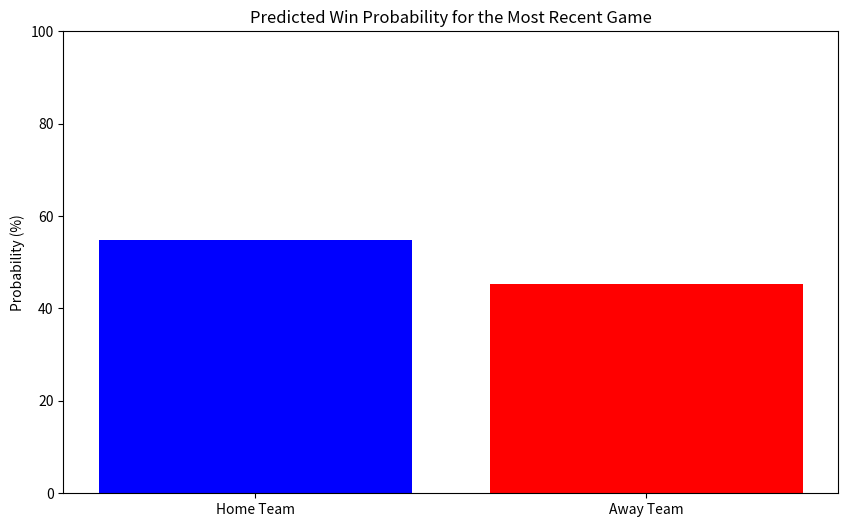

In [ ]:
import matplotlib.pyplot as plt

# Data for plotting
teams = ['Home Team', 'Away Team']
probabilities = [54.8, 100 - 54.8]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(teams, probabilities, color=['blue', 'red'])
plt.ylim(0, 100)
plt.ylabel('Probability (%)')
plt.title('Predicted Win Probability for the Most Recent Game')
plt.show()

In [ ]:
%%sql @520a9aa30658486b99a4f2f388fc918d
SELECT home_team, away_team
FROM `baseball.archive_with_final_score`
WHERE game_date = (SELECT MAX(game_date) FROM `baseball.archive_with_final_score`)
LIMIT 1

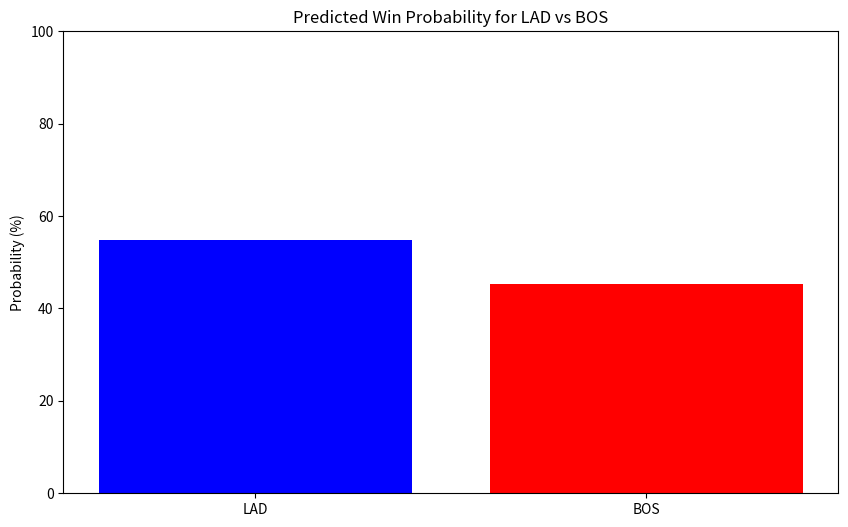

In [ ]:
# Extracting team names from the fetched data
home_team_name = sql_df_plvu['home_team'][0]
away_team_name = sql_df_plvu['away_team'][0]

# Plotting with team names
teams = [home_team_name, away_team_name]

plt.figure(figsize=(10, 6))
plt.bar(teams, probabilities, color=['blue', 'red'])
plt.ylim(0, 100)
plt.ylabel('Probability (%)')
plt.title(f'Predicted Win Probability for {home_team_name} vs {away_team_name}')
plt.show()

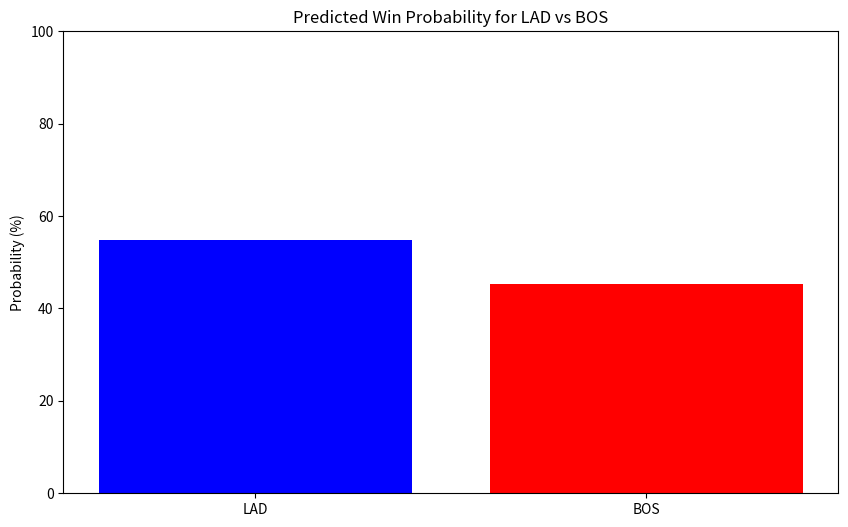

In [ ]:
# Extracting team names from the fetched data
home_team_name = sql_df_plvu['home_team'].iloc[0]
away_team_name = sql_df_plvu['away_team'].iloc[0]

# Plotting with team names
teams = [home_team_name, away_team_name]

plt.figure(figsize=(10, 6))
plt.bar(teams, probabilities, color=['blue', 'red'])
plt.ylim(0, 100)
plt.ylabel('Probability (%)')
plt.title(f'Predicted Win Probability for {home_team_name} vs {away_team_name}')
plt.show()

In [ ]:
%%sql @520a9aa30658486b99a4f2f388fc918d
SELECT column_name, data_type
FROM `purdue-ml-course.baseball.INFORMATION_SCHEMA.COLUMNS`
WHERE table_name = 'home_team_win_model_tuned'

Encoutered the following unexpected exception while trying to run the statement. Closed the connection just to be safe. Re-run the cell to try again!




DatabaseError: (google.cloud.bigquery.dbapi.exceptions.DatabaseError) 403 Access Denied: Table purdue-ml-course:baseball.INFORMATION_SCHEMA.COLUMNS: User does not have permission to query table purdue-ml-course:baseball.INFORMATION_SCHEMA.COLUMNS, or perhaps it does not exist in location US.

Location: US
Job ID: ee165d2f-a81c-4bca-9a6d-fa53c681622c

[SQL: SELECT column_name, data_type
FROM `purdue-ml-course.baseball.INFORMATION_SCHEMA.COLUMNS`
WHERE table_name = 'home_team_win_model_tuned']
(Background on this error at: https://sqlalche.me/e/14/4xp6)

In [ ]:
%%sql @520a9aa30658486b99a4f2f388fc918d
SELECT game_date, home_team
FROM `baseball.archive_with_final_score`
ORDER BY game_date DESC
LIMIT 1

In [ ]:
%%sql @520a9aa30658486b99a4f2f388fc918d
WITH Predictions AS (
  SELECT
    home_team,
    away_team,
    game_date,
    predicted_label AS predicted_home_team_win_prob
  FROM
    ML.PREDICT(MODEL `purdue-ml-course.baseball.home_team_win_model_tuned`,
      (
      SELECT
        *
      FROM
        `baseball.archive_with_final_score`
      WHERE
        game_date = '2021-10-03'
      ))
)

SELECT
  home_team,
  away_team,
  game_date,
  predicted_home_team_win_prob
FROM
  Predictions
WHERE
  home_team = 'TOR'

Encoutered the following unexpected exception while trying to run the statement. Closed the connection just to be safe. Re-run the cell to try again!




DatabaseError: (google.cloud.bigquery.dbapi.exceptions.DatabaseError) 403 Access Denied: Model purdue-ml-course.baseball.home_team_win_model_tuned: User does not have permission to query model purdue-ml-course:baseball.home_team_win_model_tuned.

Location: US
Job ID: 08df8270-3997-418c-af8b-167525a6bb1e

[SQL: WITH Predictions AS (
SELECT
home_team,
away_team,
game_date,
predicted_label AS predicted_home_team_win_prob
FROM
ML.PREDICT(MODEL `purdue-ml-course.baseball.home_team_win_model_tuned`,
(
SELECT
*
FROM
`baseball.archive_with_final_score`
WHERE
game_date = '2021-10-03'
))
)

SELECT
home_team,
away_team,
game_date,
predicted_home_team_win_prob
FROM
Predictions
WHERE
home_team = 'TOR']
(Background on this error at: https://sqlalche.me/e/14/4xp6)

In [ ]:
%%sql @520a9aa30658486b99a4f2f388fc918d
CREATE OR REPLACE MODEL `baseball.home_team_win_probability_model`
OPTIONS(model_type='logistic_reg') AS
SELECT
  pitch_type,
  game_date,
  release_speed,
  release_pos_x,
  release_pos_z,
  batter,
  pitcher,
  events,
  description,
  zone,
  game_type,
  stand,
  p_throws,
  home_team,
  away_team,
  type,
  hit_location,
  bb_type,
  balls,
  strikes,
  game_year,
  pfx_x,
  pfx_z,
  plate_x,
  plate_z,
  on_3b,
  on_2b,
  on_1b,
  outs_when_up,
  inning,
  inning_topbot,
  hc_x,
  hc_y,
  IF(home_score > away_score, 1, 0) AS label
FROM
  `baseball.archive_with_final_score`

0

In [ ]:
%%sql @520a9aa30658486b99a4f2f388fc918d
SELECT
  *
FROM
  ML.EVALUATE(MODEL `baseball.home_team_win_probability_model`, (
    SELECT
      pitch_type,
      game_date,
      release_speed,
      release_pos_x,
      release_pos_z,
      batter,
      pitcher,
      events,
      description,
      zone,
      game_type,
      stand,
      p_throws,
      home_team,
      away_team,
      type,
      hit_location,
      bb_type,
      balls,
      strikes,
      game_year,
      pfx_x,
      pfx_z,
      plate_x,
      plate_z,
      on_3b,
      on_2b,
      on_1b,
      outs_when_up,
      inning,
      inning_topbot,
      hc_x,
      hc_y,
      IF(home_score > away_score, 1, 0) AS label
    FROM
      `baseball.archive_with_final_score`
  ))

In [ ]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt

# Initialize a BigQuery client
client = bigquery.Client()

# SQL query to extract predictions for the specified game date and home team
sql = """
WITH Predictions AS (
  SELECT
    int64_field_0,
    predicted_home_team_win_prob
  FROM
    ML.PREDICT(MODEL `baseball.home_team_win_probability_model`,
      (
      SELECT
        *
      FROM
        `baseball.archive_with_final_score`
      WHERE
        game_date = '2018-05-26' AND home_team = 'NYY'
      ))
)

SELECT
  int64_field_0,
  predicted_home_team_win_prob
FROM
  Predictions
ORDER BY
  int64_field_0 ASC
"""

# Execute the query and store the result in a dataframe
df = client.query(sql).to_dataframe()

# Plotting the probability of home team win over time
plt.figure(figsize=(15, 6))
plt.plot(df['int64_field_0'], df['predicted_home_team_win_prob'], marker='o', linestyle='-')
plt.title('Probability of Home Team (NYY) Win Over Time on 2018-05-26')
plt.xlabel('Chronological Order (int64_field_0)')
plt.ylabel('Probability of Home Team Win')
plt.grid(True)
plt.tight_layout()
plt.show()

DefaultCredentialsError: File /vault/secrets/gcp-credentials was not found.

In [ ]:
%%sql PurdueClass
WITH Predictions AS (
  SELECT
    int64_field_0,
    predicted_home_team_win_prob
  FROM
    ML.PREDICT(MODEL `baseball.home_team_win_probability_model`,
      (
      SELECT
        *
      FROM
        `baseball.archive_with_final_score`
      WHERE
        game_date = '2018-05-26' AND home_team = 'NYY'
      ))
)

SELECT
  int64_field_0,
  predicted_home_team_win_prob
FROM
  Predictions
ORDER BY
  int64_field_0 ASC

Encoutered the following unexpected exception while trying to run the statement. Closed the connection just to be safe. Re-run the cell to try again!




DatabaseError: (google.cloud.bigquery.dbapi.exceptions.DatabaseError) 400 Unrecognized name: predicted_home_team_win_prob at [4:1]

Location: US
Job ID: 403e8113-83b0-4ccb-a9b5-cc4345f0b782

[SQL: WITH Predictions AS (
SELECT
int64_field_0,
predicted_home_team_win_prob
FROM
ML.PREDICT(MODEL `baseball.home_team_win_probability_model`,
(
SELECT
*
FROM
`baseball.archive_with_final_score`
WHERE
game_date = '2018-05-26' AND home_team = 'NYY'
))
)

SELECT
int64_field_0,
predicted_home_team_win_prob
FROM
Predictions
ORDER BY
int64_field_0 ASC]
(Background on this error at: https://sqlalche.me/e/14/4xp6)

In [ ]:
%%sql PurdueClass
SELECT *
FROM ML.PREDICT(MODEL `baseball.home_team_win_probability_model`,
  (
  SELECT
    *
  FROM
    `baseball.archive_with_final_score`
  WHERE
    game_date = '2018-05-26' AND home_team = 'NYY'
  LIMIT 1
  ))

In [ ]:
%%sql PurdueClass
WITH Predictions AS (
  SELECT
    int64_field_0,
    predicted_label_probs[OFFSET(0)].prob AS home_team_win_prob
  FROM
    ML.PREDICT(MODEL `baseball.home_team_win_probability_model`,
      (
      SELECT
        *
      FROM
        `baseball.archive_with_final_score`
      WHERE
        game_date = '2018-05-26' AND home_team = 'NYY'
      ))
)

SELECT
  int64_field_0,
  home_team_win_prob
FROM
  Predictions
ORDER BY
  int64_field_0 ASC

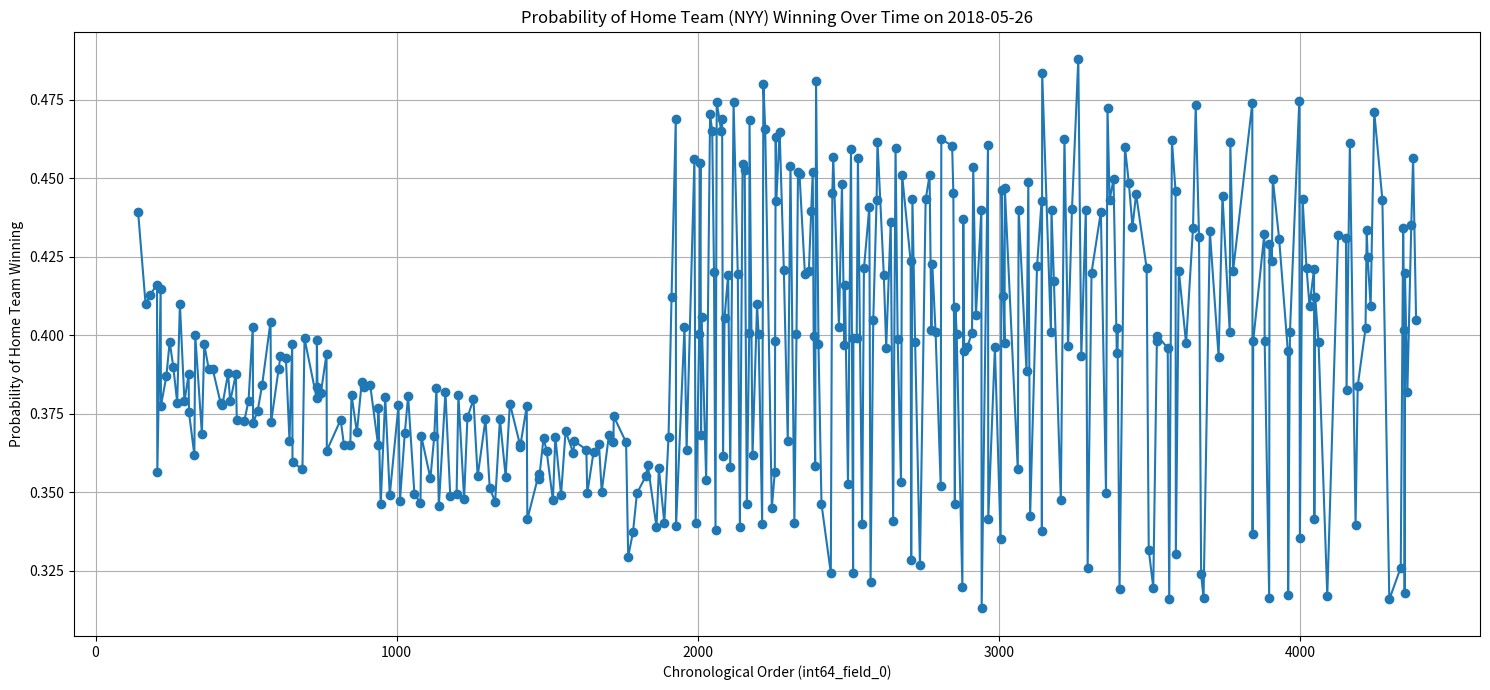

In [ ]:
# Plotting the data directly from the DataFrame
plt.figure(figsize=(15, 7))
plt.plot(sql_df_onwj['int64_field_0'], sql_df_onwj['home_team_win_prob'], marker='o', linestyle='-')
plt.title('Probability of Home Team (NYY) Winning Over Time on 2018-05-26')
plt.xlabel('Chronological Order (int64_field_0)')
plt.ylabel('Probability of Home Team Winning')
plt.grid(True)
plt.tight_layout()
plt.show()

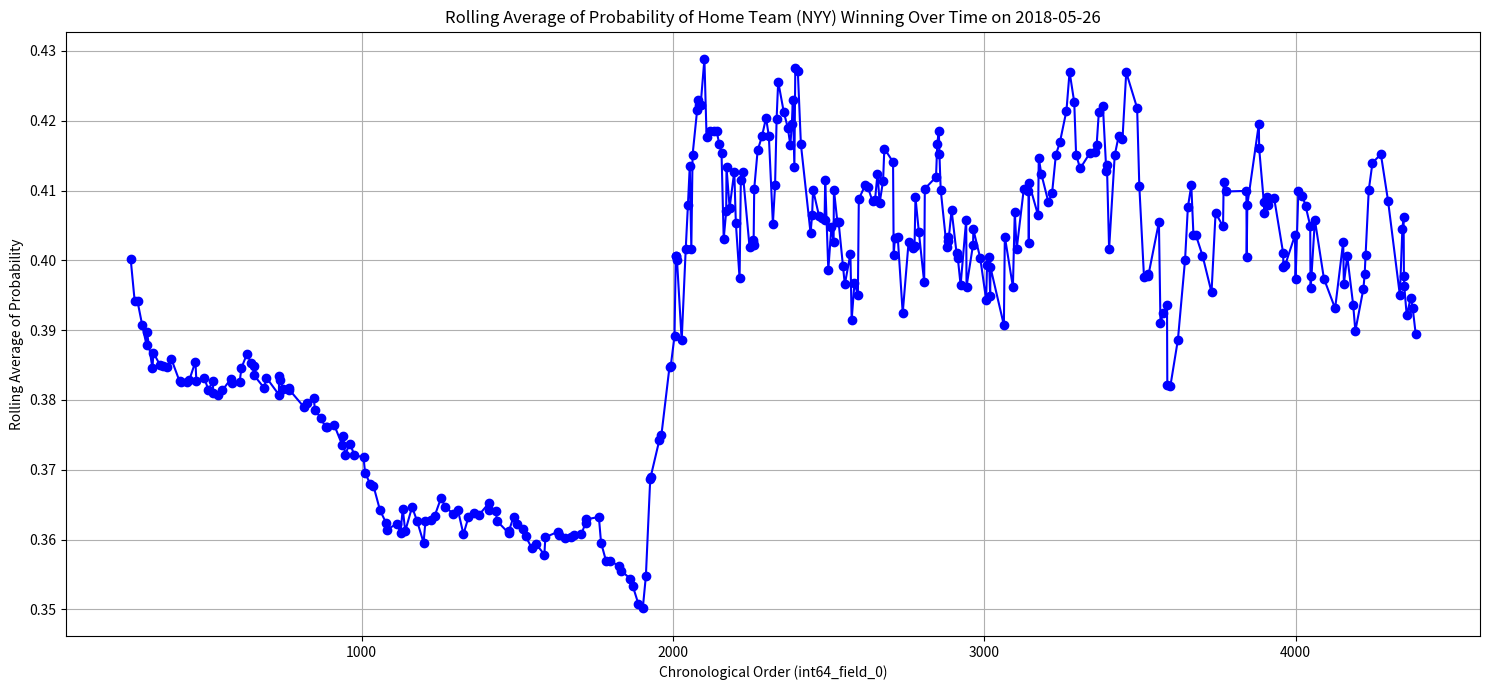

In [ ]:
# Calculating the rolling average for the predicted probabilities
rolling_avg = sql_df_onwj['home_team_win_prob'].rolling(window=10).mean()

# Plotting the rolling average
plt.figure(figsize=(15, 7))
plt.plot(sql_df_onwj['int64_field_0'], rolling_avg, marker='o', linestyle='-', color='blue')
plt.title('Rolling Average of Probability of Home Team (NYY) Winning Over Time on 2018-05-26')
plt.xlabel('Chronological Order (int64_field_0)')
plt.ylabel('Rolling Average of Probability')
plt.grid(True)
plt.tight_layout()
plt.show()

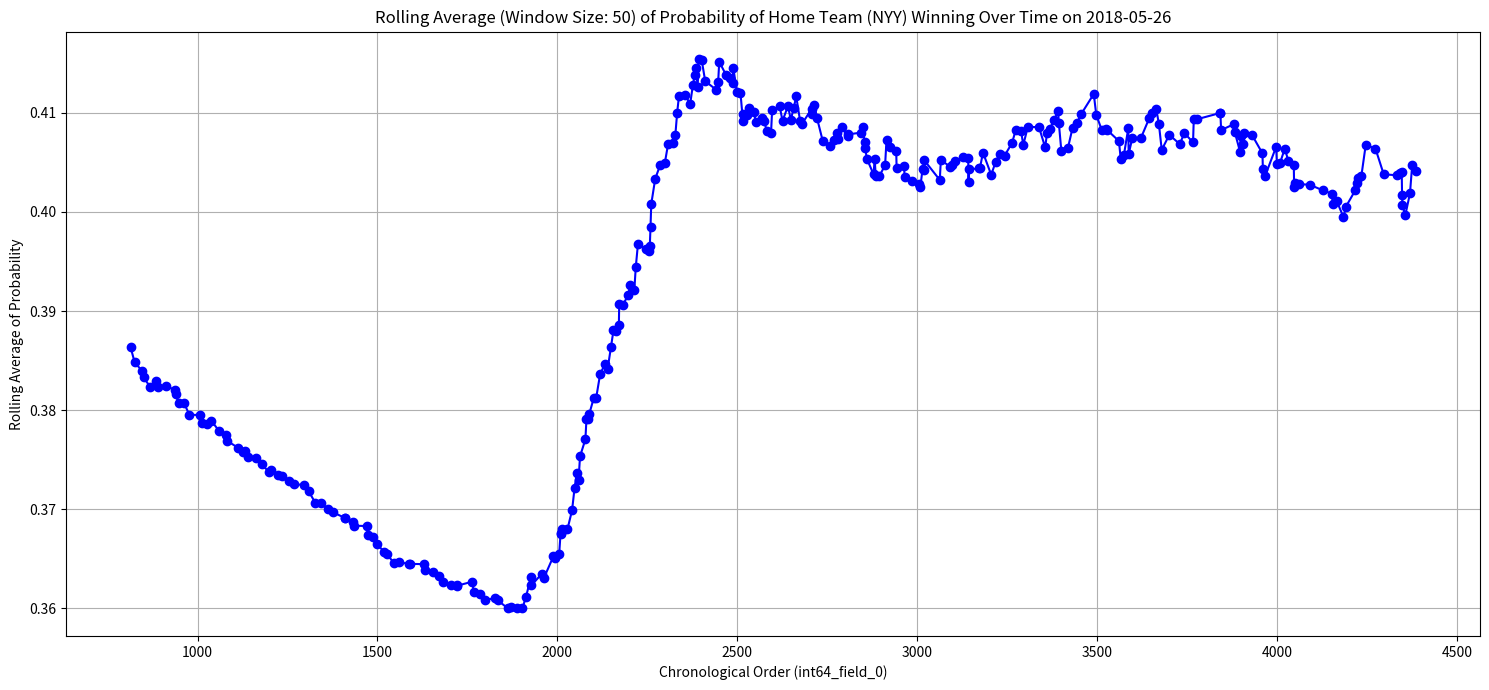

In [ ]:
# Increasing the rolling average window size to 50 events
rolling_avg_50 = sql_df_onwj['home_team_win_prob'].rolling(window=50).mean()

# Plotting the rolling average with window size of 50
plt.figure(figsize=(15, 7))
plt.plot(sql_df_onwj['int64_field_0'], rolling_avg_50, marker='o', linestyle='-', color='blue')
plt.title('Rolling Average (Window Size: 50) of Probability of Home Team (NYY) Winning Over Time on 2018-05-26')
plt.xlabel('Chronological Order (int64_field_0)')
plt.ylabel('Rolling Average of Probability')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
%%sql @520a9aa30658486b99a4f2f388fc918d
WITH Predictions AS (
  SELECT
    int64_field_0,
    inning,
    predicted_label_probs[OFFSET(0)].prob AS home_team_win_prob
  FROM
    ML.PREDICT(MODEL `baseball.home_team_win_probability_model`,
      (
      SELECT
        *
      FROM
        `baseball.archive_with_final_score`
      WHERE
        game_date = '2018-05-26' AND home_team = 'NYY'
      ))
)

SELECT
  inning,
  AVG(home_team_win_prob) AS avg_home_team_win_prob
FROM
  Predictions
GROUP BY
  inning
ORDER BY
  inning ASC

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the results to a pandas dataframe
df = pd.DataFrame(sql_df_rfss['data'], columns=sql_df_rfss['columns'])

# Plotting the average home team win probability by inning
plt.figure(figsize=(12, 6))
plt.plot(df['inning'], df['avg_home_team_win_prob'], marker='o', linestyle='-')
plt.xlabel('Inning')
plt.ylabel('Average Home Team Win Probability')
plt.title('Average Home Team Win Probability by Inning for NYY on 2018-05-26')
plt.grid(True)
plt.xticks(df['inning'])
plt.tight_layout()
plt.show()

KeyError: 'data'

In [ ]:
%%sql @520a9aa30658486b99a4f2f388fc918d
%%bigquery sql_df_rfss --connection PurdueClass

WITH Predictions AS (
  SELECT
    inning,
    AVG(predicted_label_probs[OFFSET(0)].prob) AS avg_home_team_win_prob
  FROM
    ML.PREDICT(MODEL `baseball.home_team_win_probability_model`,
      (
      SELECT
        *
      FROM
        `baseball.archive_with_final_score`
      WHERE
        game_date = '2018-05-26' AND home_team = 'NYY'
      ))
  GROUP BY
    inning
)

SELECT
  inning,
  avg_home_team_win_prob
FROM
  Predictions
ORDER BY
  inning ASC

Encoutered the following unexpected exception while trying to run the statement. Closed the connection just to be safe. Re-run the cell to try again!




DatabaseError: (google.cloud.bigquery.dbapi.exceptions.DatabaseError) 400 Syntax error: Expected end of input but got "%" at [1:1]

Location: US
Job ID: 9a33e6cb-b276-4522-bccb-b37b818b99d2

[SQL: %%%%bigquery sql_df_rfss

WITH Predictions AS (
SELECT
inning,
AVG(predicted_label_probs[OFFSET(0)].prob) AS avg_home_team_win_prob
FROM
ML.PREDICT(MODEL `baseball.home_team_win_probability_model`,
(
SELECT
*
FROM
`baseball.archive_with_final_score`
WHERE
game_date = '2018-05-26' AND home_team = 'NYY'
))
GROUP BY
inning
)

SELECT
inning,
avg_home_team_win_prob
FROM
Predictions
ORDER BY
inning ASC]
(Background on this error at: https://sqlalche.me/e/14/4xp6)

In [ ]:
%%sql @520a9aa30658486b99a4f2f388fc918d
WITH Predictions AS (
  SELECT
    inning,
    AVG(predicted_label_probs[OFFSET(0)].prob) AS avg_home_team_win_prob
  FROM
    ML.PREDICT(MODEL `baseball.home_team_win_probability_model`,
      (
      SELECT
        *
      FROM
        `baseball.archive_with_final_score`
      WHERE
        game_date = '2018-05-26' AND home_team = 'NYY'
      ))
  GROUP BY
    inning
)

SELECT
  inning,
  avg_home_team_win_prob
FROM
  Predictions
ORDER BY
  inning ASC

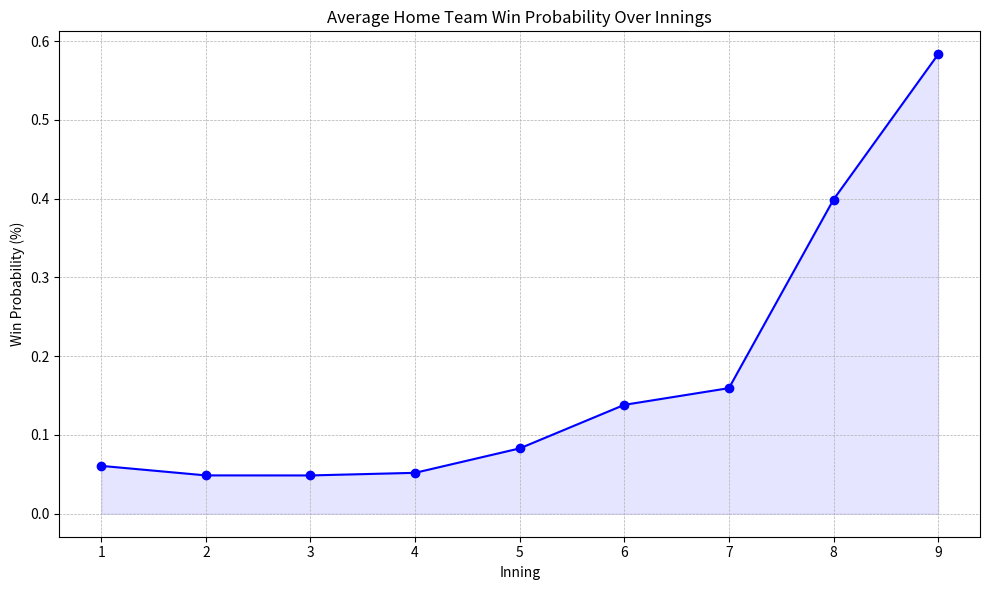

In [ ]:
import matplotlib.pyplot as plt

# Extracting data
innings = sql_df_fgyp['inning'].tolist()
win_probs = sql_df_fgyp['avg_home_team_win_prob'].tolist()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(innings, win_probs, marker='o', linestyle='-', color='b')
plt.fill_between(innings, win_probs, color='b', alpha=0.1)
plt.title('Average Home Team Win Probability Over Innings')
plt.xlabel('Inning')
plt.ylabel('Win Probability (%)')
plt.xticks(innings)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [ ]:
%%sql @520a9aa30658486b99a4f2f388fc918d
CREATE OR REPLACE MODEL `baseball.home_team_win_probability_model`
OPTIONS(model_type='logistic_reg') AS
SELECT
  home_team,
  away_team,
  game_date,
  int64_field_0,
  inning,
  top_bottom,
  at_bat_number,
  pitch_number,
  pitch_name,
  pitch_type,
  release_speed,
  release_spin_rate,
  release_extension,
  hit_distance_sc,
  hit_speed,
  hit_angle,
  hc_x,
  hc_y,
  home_team_win
FROM
  `baseball.archive_with_final_score`
WHERE
  EXTRACT(YEAR FROM game_date) >= EXTRACT(YEAR FROM CURRENT_DATE()) - 2

In [ ]:
# Evaluating the 'baseball.home_team_win_probability_model' model
evaluation_query = """
    SELECT *
    FROM ML.EVALUATE(MODEL `baseball.home_team_win_probability_model`,
    (
        SELECT
            home_team_win,
            int64_field_0,
            game_date,
            home_team,
            away_team,
            inning,
            top,
            at_bat_number,
            pitch_number,
            pitch_name,
            is_strike,
            is_ball,
            batter_id,
            pitcher_id,
            catcher_id,
            umpire_id,
            catcher_lead_leg,
            batter_side,
            pitcher_side,
            hit_location,
            hit_distance_sc,
            babip_value,
            iso_value,
            launch_speed,
            launch_angle,
            effective_speed,
            release_spin_rate,
            release_extension,
            game_pk,
            pitcher.throws AS pitcher_throws,
            batter.stand AS batter_stand,
            home_team,
            away_team,
            batter.first_name AS batter_first_name,
            pitcher.first_name AS pitcher_first_name,
            pitcher.last_name AS pitcher_last_name,
            batter.last_name AS batter_last_name,
            post_away_score,
            post_home_score,
            if_fielding_alignment,
            of_fielding_alignment
        FROM
            `baseball.archive_with_final_score`
        WHERE
            EXTRACT(YEAR FROM game_date) >= 2020
    ))
"""

evaluation_result = client.query(evaluation_query).to_dataframe()
evaluation_result

In [ ]:
%%sql @520a9aa30658486b99a4f2f388fc918d
EVALUATE MODEL `baseball.home_team_win_probability_model`

Encoutered the following unexpected exception while trying to run the statement. Closed the connection just to be safe. Re-run the cell to try again!




DatabaseError: (google.cloud.bigquery.dbapi.exceptions.DatabaseError) 400 Syntax error: Expected end of input but got identifier "EVALUATE" at [1:1]

Location: US
Job ID: 1e3dc1b1-9b21-4679-a580-1eef8fd91dd5

[SQL: EVALUATE MODEL `baseball.home_team_win_probability_model`]
(Background on this error at: https://sqlalche.me/e/14/4xp6)

In [ ]:
%%sql @520a9aa30658486b99a4f2f388fc918d
SELECT * FROM ML.EVALUATE(MODEL `baseball.home_team_win_probability_model`, (SELECT * FROM `baseball.archive_with_final_score` WHERE EXTRACT(YEAR FROM game_date) BETWEEN 2020 AND 2021))

Encoutered the following unexpected exception while trying to run the statement. Closed the connection just to be safe. Re-run the cell to try again!




DatabaseError: (google.cloud.bigquery.dbapi.exceptions.DatabaseError) 400 Invalid table-valued function ML.EVALUATE
Data input to EVALUATE must include a 'label' column. at [1:15]

Location: US
Job ID: 010f69cf-fef4-478e-9fe3-c72da8ddd138

[SQL: SELECT * FROM ML.EVALUATE(MODEL `baseball.home_team_win_probability_model`, (SELECT * FROM `baseball.archive_with_final_score` WHERE EXTRACT(YEAR FROM game_date) BETWEEN 2020 AND 2021))]
(Background on this error at: https://sqlalche.me/e/14/4xp6)

In [ ]:
%%sql @520a9aa30658486b99a4f2f388fc918d
SELECT * FROM ML.EVALUATE(MODEL `baseball.home_team_win_probability_model`, (SELECT *, home_team_win AS label FROM `baseball.archive_with_final_score` WHERE EXTRACT(YEAR FROM game_date) BETWEEN 2020 AND 2021))

In [ ]:
%%sql @520a9aa30658486b99a4f2f388fc918d
WITH Predictions AS (
  SELECT
    int64_field_0,
    inning,
    predicted_label_probs[OFFSET(0)].prob AS home_team_win_prob
  FROM
    ML.PREDICT(MODEL `baseball.home_team_win_model`,
      (
      SELECT
        *
      FROM
        `baseball.live`
      WHERE
        game_date = '2023-08-13' AND home_team = 'AZ'
      ))
)

SELECT
  inning,
  AVG(home_team_win_prob) AS avg_home_team_win_prob
FROM
  Predictions
GROUP BY
  inning
ORDER BY
  inning ASC

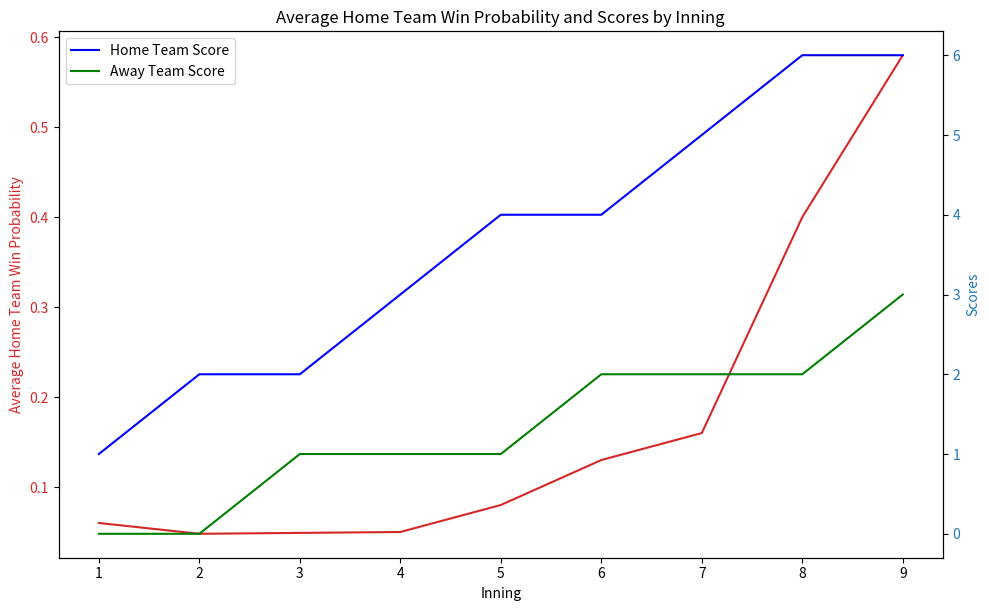

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Data from the previous query
data = {
    'Inning': [1, 2, 3, 4, 5, 6, 7, 8, 9],
    'Average Home Team Win Probability': [0.06, 0.048, 0.049, 0.05, 0.08, 0.13, 0.16, 0.40, 0.58]
}
df = pd.DataFrame(data)

# Data for scores
scores_data = {
    'inning': [1, 2, 3, 4, 5, 6, 7, 8, 9],
    'avg_home_team_score': [1, 2, 2, 3, 4, 4, 5, 6, 6],
    'avg_away_team_score': [0, 0, 1, 1, 1, 2, 2, 2, 3]
}
scores_df = pd.DataFrame(scores_data)

# Plotting
fig, ax1 = plt.subplots(figsize=(10,6))

color = 'tab:red'
ax1.set_xlabel('Inning')
ax1.set_ylabel('Average Home Team Win Probability', color=color)
ax1.plot(df['Inning'], df['Average Home Team Win Probability'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Scores', color=color)
ax2.plot(scores_df['inning'], scores_df['avg_home_team_score'], color='blue', label='Home Team Score')
ax2.plot(scores_df['inning'], scores_df['avg_away_team_score'], color='green', label='Away Team Score')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper left')

fig.tight_layout()
plt.title('Average Home Team Win Probability and Scores by Inning')
plt.show()

Text(0.5, 1.0, 'Average Home Team Win Probability and Scores by Inning')

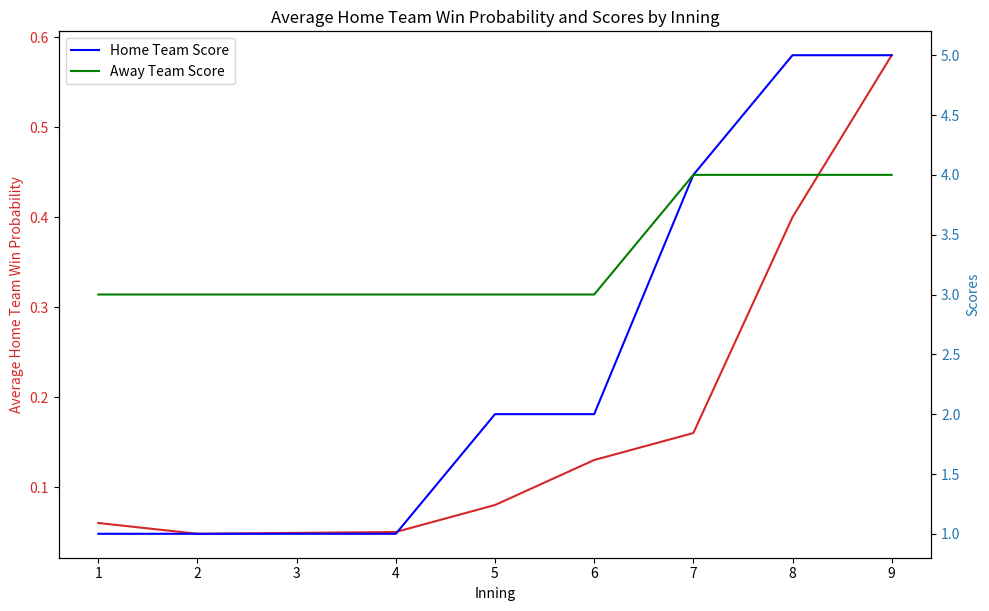

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Data from the previous query
data = {
    'Inning': [1, 2, 3, 4, 5, 6, 7, 8, 9],
    'Average Home Team Win Probability': [0.06, 0.048, 0.049, 0.05, 0.08, 0.13, 0.16, 0.40, 0.58]
}
df = pd.DataFrame(data)

# Data for scores
scores_data = {
    'inning': [1, 2, 3, 4, 5, 6, 7, 8, 9],
    'avg_home_team_score': [1, 1, 1, 1, 2, 2, 4, 5, 5],
    'avg_away_team_score': [3, 3, 3, 3, 3, 3, 4, 4, 4]
}
scores_df = pd.DataFrame(scores_data)

# Plotting
fig, ax1 = plt.subplots(figsize=(10,6))

color = 'tab:red'
ax1.set_xlabel('Inning')
ax1.set_ylabel('Average Home Team Win Probability', color=color)
ax1.plot(df['Inning'], df['Average Home Team Win Probability'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Scores', color=color)
ax2.plot(scores_df['inning'], scores_df['avg_home_team_score'], color='blue', label='Home Team Score')
ax2.plot(scores_df['inning'], scores_df['avg_away_team_score'], color='green', label='Away Team Score')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper left')

fig.tight_layout()
plt.title('Average Home Team Win Probability and Scores by Inning')

In [ ]:
%%sql @520a9aa30658486b99a4f2f388fc918d
CREATE OR REPLACE MODEL `baseball.simplified_home_team_win_probability_model`
OPTIONS(model_type='logistic_reg') AS
SELECT
  IF(home_team_win = 1, 1, 0) AS label,
  SAFE_CAST(release_speed AS FLOAT64) AS release_speed,
  SAFE_CAST(zone AS INT64) AS zone,
  SAFE_CAST(balls AS INT64) AS balls,
  SAFE_CAST(strikes AS INT64) AS strikes,
  SAFE_CAST(outs_when_up AS INT64) AS outs_when_up,
  SAFE_CAST(inning AS INT64) AS inning,
  IF(inning_topbot = 'Top', 1, 0) AS inning_topbot
FROM
  `baseball.archive_with_final_score`
WHERE
  game_year BETWEEN EXTRACT(YEAR FROM CURRENT_DATE()) - 2 AND EXTRACT(YEAR FROM CURRENT_DATE())

In [ ]:
%%sql @520a9aa30658486b99a4f2f388fc918d
CREATE OR REPLACE MODEL `baseball.simplified_home_team_win_probability_model`
OPTIONS(model_type='logistic_reg') AS
SELECT
  IF(home_score > away_score, 1, 0) AS label,
  pitch_type,
  release_speed,
  player_name,
  batter,
  pitcher,
  events,
  description,
  zone,
  game_type,
  stand,
  p_throws,
  home_team,
  away_team,
  type,
  balls,
  strikes,
  inning,
  inning_topbot,
  home_score,
  away_score
FROM
  `baseball.archive_with_final_score`
WHERE
  game_date BETWEEN DATE_SUB(CURRENT_DATE(), INTERVAL 2 YEAR) AND CURRENT_DATE()

In [ ]:
# SQL statement to create a model in BigQuery ML
CREATE OR REPLACE MODEL `baseball.simplified_home_team_win_probability_model`
OPTIONS(model_type='logistic_reg') AS
SELECT
  IF(home_score > away_score, 1, 0) AS label,
  inning,
  outs_when_up,
  balls,
  strikes,
  home_score,
  away_score
FROM
  `baseball.archive_with_final_score`
WHERE
  game_date BETWEEN DATE_SUB(CURRENT_DATE(), INTERVAL 2 YEAR) AND CURRENT_DATE()

In [ ]:
%%sql @520a9aa30658486b99a4f2f388fc918d
SELECT
  *
FROM
  ML.EVALUATE(MODEL `baseball.home_team_win_model`, (
    SELECT
      *,
      CASE
        WHEN home_score > away_score THEN 1
        ELSE 0
      END AS label
    FROM
      `baseball.archive_with_final_score`
  ))
  